In [204]:
import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms, utils
from torch.utils import data
from tqdm.notebook import tqdm
from torch.utils.data.dataloader import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
def to_byte(payload):
    out = []
    for ii in range(0, len(payload), 2):
        out.append(int(payload[ii : ii + 2], 16) + 1)
    return out

In [258]:
ae_train_data = []
ae_valid_data = []
train_data = []
train_label = []
valid_data = []
valid_label = []
test_data = []
test_label = []
for idx, file in enumerate(tqdm(os.listdir(save_enc))):
    with open(rf"{save_enc}\{file}", 'rb') as  f:
        tmp = pickle.load(f)
        if len(tmp) < 1500:
            tmp.extend([0] * (1500-len(tmp)))
        if idx % 5 == 0:
            test_data.append(tmp[:1500])
            test_label.append(1)
        elif idx % 5 == 1:
            valid_data.append(tmp[:1500])
            valid_label.append(1)
        else:
            train_data.append(tmp[:1500])
            train_label.append(1)
        ae_valid_data.append(tmp[:1500])
            
for idx, file in enumerate(tqdm(os.listdir(save_plain)[:1300], total = 1300)):
    with open(rf"{save_plain}\{file}", 'rb') as  f:
        tmp = pickle.load(f)
        if len(tmp) < 1500:
            tmp.extend([0] * (1500-len(tmp)))
        if idx % 5 == 0:
            test_data.append(tmp[:1500])
            test_label.append(0)
        elif idx % 5 == 1:
            valid_data.append(tmp[:1500])
            valid_label.append(0)
        else:
            train_data.append(tmp[:1500])
            train_label.append(0)
        ae_train_data.append(tmp[:1500])

  0%|          | 0/1306 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

In [176]:
def tmp_devide(x):
    return x/256

class MyDataset(Dataset):
    def __init__(self, data, label):
        super(MyDataset, self).__init__()
        self.data = data
        self.label = label
        self.scaling_data = []
        self.scale_data()
        
    def scale_data(self):
        for tmp_data in self.data:
            self.scaling_data.append(list(map(tmp_devide, tmp_data)))
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.scaling_data[idx]), torch.tensor(self.data[idx][:300]), torch.tensor(self.label[idx])
    
class AeDataset(Dataset):
    def __init__(self, data):
        super(AeDataset, self).__init__()
        self.data = data
        self.scaling_data = []
        self.scale_data()
        
    def scale_data(self):
        for tmp_data in self.data:
            self.scaling_data.append(list(map(tmp_devide, tmp_data)))
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.scaling_data[idx])
#         return torch.tensor(self.data[idx])

In [238]:
ae_epoch = 128
dnn_epoch = 128
header_dims = 300
window_size = 5
input_dims = 1500
batch_size = 16
lr = 1e-4

In [194]:
train_dataset = MyDataset(train_data, train_label)
valid_dataset = MyDataset(valid_data, valid_label)
test_dataset = MyDataset(test_data, test_label)
ae_train_dataset = AeDataset(ae_train_data)
ae_valid_dataset = AeDataset(ae_valid_data)

In [195]:
train_loader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ae_train_loader = data.DataLoader(ae_train_dataset, batch_size = batch_size, shuffle=True)
ae_valid_loader = data.DataLoader(ae_valid_dataset, batch_size = batch_size, shuffle=True)

In [196]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dims=1500):
        super(AutoEncoder, self).__init__()
        self.input_dims = input_dims
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dims, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.LeakyReLU()
            )

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,self.input_dims)
            )
    
    def forward(self, payload):
        enc_x = self.encoder(payload)
        dec_x = self.decoder(enc_x)
        return dec_x

In [197]:
class DNN(nn.Module):
    def __init__(self, auto_encoder, header_dims = 300, input_dims=1500, window_size=5):
        super(DNN, self).__init__()
        self.input_dims = input_dims
        self.auto_encoder = auto_encoder
        self.embed = nn.Embedding(257, 8, padding_idx=0)
        self.conv_1 = nn.Conv1d(8, 16, window_size, stride=1, padding=2)
        self.pool1 = nn.AvgPool1d(2,2) # 150
        self.conv_2 = nn.Conv1d(16, 32, window_size, stride=1, padding=2)
        self.pool2 = nn.AvgPool1d(2,2) # 75 
        self.conv_3 = nn.Conv1d(32, 64, window_size, stride=1, padding=2)
        self.pool3 = nn.AvgPool1d(5,5) # 15 
        self.conv_4 = nn.Conv1d(64, 128, window_size, stride=1, padding=2)
        self.pool4 = nn.AvgPool1d(5,5) # 3 
        
        self.pooling = nn.MaxPool1d(3)
        
        self.fc_1 = nn.Linear(128, 10)
        self.fc_2 = nn.Linear(11, 5)
        self.fc_3 = nn.Linear(5, 1)
        
        self.leakyReLU = nn.LeakyReLU()
        
    def forward(self, payload, header):
        ae_output = self.auto_encoder(payload)
        rce = torch.mean(F.mse_loss(ae_output, payload, reduction='none'), dim=1)
        x = self.embed(header)
        x = torch.transpose(x, -1, -2)
        x = self.pool1(self.leakyReLU(self.conv_1(x)))
        x = self.pool2(self.leakyReLU(self.conv_2(x)))
        x = self.pool3(self.leakyReLU(self.conv_3(x)))
        x = self.pool4(self.leakyReLU(self.conv_4(x)))
        
        x = self.pooling(x)
        x = self.leakyReLU(x.view(-1,128))
        x = self.leakyReLU(self.fc_1(x))
        rce = self.leakyReLU(rce.view(-1, 1))
        x = torch.cat([x, rce], dim=1)
        x = self.leakyReLU(self.fc_2(x))
        x= torch.sigmoid(self.fc_3(x))
        return x

In [252]:
ae_model = AutoEncoder(input_dims).to(device)
optimizer = torch.optim.AdamW(ae_model.parameters())
criterion = F.mse_loss

In [253]:
def get_label_loss(label, recon_error):
    attack_loss = []
    benign_loss = []
    for i in range(len(label)):
        if label[i] == 'BENIGN':
            benign_loss.append(recon_error[i])
        else:
            attack_loss.append(recon_error[i])
    return benign_loss, attack_loss

In [254]:
### AutoEncoder Training ###
pbar = tqdm(range(ae_epoch), desc="AE training")
train_loss_list = []
test_loss_list = []
for e in pbar:
    ae_model.train()
    train_running_loss = 0.0
    for idx, batch in enumerate(tqdm(ae_train_loader)):
        payload = batch
        payload = payload.to(device)
        output = ae_model(payload)
        loss = criterion(output, payload)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.detach().item()
        pbar.set_postfix(ae_epoch=f"{e + 1} of {ae_epoch}", loss=f"{loss:.8f}")
    print('Epoch: %d | Loss: %.4f' \
      %(e + 1, train_running_loss/(idx+1))) 
    train_loss_list.append(float(train_running_loss/(idx+1)))
    ae_model.eval()
    val_loss = 0.0
    for idx, batch in enumerate(ae_valid_loader):
        payload = batch
        payload = payload.to(device)
        output = ae_model(payload)
        loss = criterion(output, payload)
        val_loss += loss.detach().item()
    print('Epoch: %d | Val Loss: %.4f' \
      %(e + 1, val_loss/(idx+1))) 
    test_loss_list.append(val_loss/(idx+1))
    print("##############" * 3)

AE training:   0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.1255
Epoch: 1 | Val Loss: 0.1423
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 2 | Loss: 0.0851
Epoch: 2 | Val Loss: 0.1037
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 3 | Loss: 0.0818
Epoch: 3 | Val Loss: 0.0889
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 4 | Loss: 0.0802
Epoch: 4 | Val Loss: 0.0825
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.0795
Epoch: 5 | Val Loss: 0.0731
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 6 | Loss: 0.0788
Epoch: 6 | Val Loss: 0.0712
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 7 | Loss: 0.0781
Epoch: 7 | Val Loss: 0.0704
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 8 | Loss: 0.0771
Epoch: 8 | Val Loss: 0.0704
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 9 | Loss: 0.0767
Epoch: 9 | Val Loss: 0.0713
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 10 | Loss: 0.0765
Epoch: 10 | Val Loss: 0.0764
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 11 | Loss: 0.0769
Epoch: 11 | Val Loss: 0.0695
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 12 | Loss: 0.0758
Epoch: 12 | Val Loss: 0.0715
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 13 | Loss: 0.0754
Epoch: 13 | Val Loss: 0.0708
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 14 | Loss: 0.0751
Epoch: 14 | Val Loss: 0.0725
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 15 | Loss: 0.0752
Epoch: 15 | Val Loss: 0.0704
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 16 | Loss: 0.0751
Epoch: 16 | Val Loss: 0.0723
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 17 | Loss: 0.0741
Epoch: 17 | Val Loss: 0.0723
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 18 | Loss: 0.0740
Epoch: 18 | Val Loss: 0.0730
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 19 | Loss: 0.0737
Epoch: 19 | Val Loss: 0.0736
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 20 | Loss: 0.0735
Epoch: 20 | Val Loss: 0.0714
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 21 | Loss: 0.0734
Epoch: 21 | Val Loss: 0.0767
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 22 | Loss: 0.0732
Epoch: 22 | Val Loss: 0.0771
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 23 | Loss: 0.0728
Epoch: 23 | Val Loss: 0.0726
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 24 | Loss: 0.0724
Epoch: 24 | Val Loss: 0.0757
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 25 | Loss: 0.0722
Epoch: 25 | Val Loss: 0.0726
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 26 | Loss: 0.0722
Epoch: 26 | Val Loss: 0.0731
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 27 | Loss: 0.0720
Epoch: 27 | Val Loss: 0.0741
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 28 | Loss: 0.0717
Epoch: 28 | Val Loss: 0.0775
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 29 | Loss: 0.0714
Epoch: 29 | Val Loss: 0.0690
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 30 | Loss: 0.0712
Epoch: 30 | Val Loss: 0.0739
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 31 | Loss: 0.0709
Epoch: 31 | Val Loss: 0.0711
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 32 | Loss: 0.0708
Epoch: 32 | Val Loss: 0.0671
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 33 | Loss: 0.0706
Epoch: 33 | Val Loss: 0.0741
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 34 | Loss: 0.0704
Epoch: 34 | Val Loss: 0.0721
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 35 | Loss: 0.0703
Epoch: 35 | Val Loss: 0.0823
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 36 | Loss: 0.0700
Epoch: 36 | Val Loss: 0.0733
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 37 | Loss: 0.0699
Epoch: 37 | Val Loss: 0.0866
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 38 | Loss: 0.0693
Epoch: 38 | Val Loss: 0.0769
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 39 | Loss: 0.0690
Epoch: 39 | Val Loss: 0.0737
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 40 | Loss: 0.0689
Epoch: 40 | Val Loss: 0.0718
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 41 | Loss: 0.0686
Epoch: 41 | Val Loss: 0.0748
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 42 | Loss: 0.0682
Epoch: 42 | Val Loss: 0.0806
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 43 | Loss: 0.0680
Epoch: 43 | Val Loss: 0.0797
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 44 | Loss: 0.0678
Epoch: 44 | Val Loss: 0.0745
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 45 | Loss: 0.0675
Epoch: 45 | Val Loss: 0.0795
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 46 | Loss: 0.0672
Epoch: 46 | Val Loss: 0.0754
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 47 | Loss: 0.0670
Epoch: 47 | Val Loss: 0.0788
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 48 | Loss: 0.0666
Epoch: 48 | Val Loss: 0.0765
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 49 | Loss: 0.0662
Epoch: 49 | Val Loss: 0.0770
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 50 | Loss: 0.0662
Epoch: 50 | Val Loss: 0.0818
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 51 | Loss: 0.0658
Epoch: 51 | Val Loss: 0.0792
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 52 | Loss: 0.0655
Epoch: 52 | Val Loss: 0.0755
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 53 | Loss: 0.0651
Epoch: 53 | Val Loss: 0.0747
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 54 | Loss: 0.0648
Epoch: 54 | Val Loss: 0.0815
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 55 | Loss: 0.0645
Epoch: 55 | Val Loss: 0.0764
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 56 | Loss: 0.0641
Epoch: 56 | Val Loss: 0.0829
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 57 | Loss: 0.0640
Epoch: 57 | Val Loss: 0.0731
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 58 | Loss: 0.0644
Epoch: 58 | Val Loss: 0.0721
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 59 | Loss: 0.0642
Epoch: 59 | Val Loss: 0.0774
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 60 | Loss: 0.0637
Epoch: 60 | Val Loss: 0.0791
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 61 | Loss: 0.0631
Epoch: 61 | Val Loss: 0.0770
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 62 | Loss: 0.0628
Epoch: 62 | Val Loss: 0.0816
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 63 | Loss: 0.0629
Epoch: 63 | Val Loss: 0.0781
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 64 | Loss: 0.0625
Epoch: 64 | Val Loss: 0.0732
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 65 | Loss: 0.0626
Epoch: 65 | Val Loss: 0.0874
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 66 | Loss: 0.0619
Epoch: 66 | Val Loss: 0.0761
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 67 | Loss: 0.0615
Epoch: 67 | Val Loss: 0.0732
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 68 | Loss: 0.0612
Epoch: 68 | Val Loss: 0.0774
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 69 | Loss: 0.0612
Epoch: 69 | Val Loss: 0.0769
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 70 | Loss: 0.0611
Epoch: 70 | Val Loss: 0.0772
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 71 | Loss: 0.0611
Epoch: 71 | Val Loss: 0.0765
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 72 | Loss: 0.0606
Epoch: 72 | Val Loss: 0.0743
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 73 | Loss: 0.0604
Epoch: 73 | Val Loss: 0.0767
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 74 | Loss: 0.0603
Epoch: 74 | Val Loss: 0.0750
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 75 | Loss: 0.0601
Epoch: 75 | Val Loss: 0.0759
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 76 | Loss: 0.0599
Epoch: 76 | Val Loss: 0.0824
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 77 | Loss: 0.0596
Epoch: 77 | Val Loss: 0.0852
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 78 | Loss: 0.0597
Epoch: 78 | Val Loss: 0.0772
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 79 | Loss: 0.0594
Epoch: 79 | Val Loss: 0.0749
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 80 | Loss: 0.0593
Epoch: 80 | Val Loss: 0.0790
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 81 | Loss: 0.0593
Epoch: 81 | Val Loss: 0.0845
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 82 | Loss: 0.0591
Epoch: 82 | Val Loss: 0.0760
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 83 | Loss: 0.0590
Epoch: 83 | Val Loss: 0.0763
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 84 | Loss: 0.0589
Epoch: 84 | Val Loss: 0.0770
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 85 | Loss: 0.0586
Epoch: 85 | Val Loss: 0.0752
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 86 | Loss: 0.0587
Epoch: 86 | Val Loss: 0.0835
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 87 | Loss: 0.0587
Epoch: 87 | Val Loss: 0.0801
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 88 | Loss: 0.0584
Epoch: 88 | Val Loss: 0.0804
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 89 | Loss: 0.0582
Epoch: 89 | Val Loss: 0.0766
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 90 | Loss: 0.0580
Epoch: 90 | Val Loss: 0.0809
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 91 | Loss: 0.0579
Epoch: 91 | Val Loss: 0.0781
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 92 | Loss: 0.0578
Epoch: 92 | Val Loss: 0.0795
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 93 | Loss: 0.0580
Epoch: 93 | Val Loss: 0.0742
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 94 | Loss: 0.0581
Epoch: 94 | Val Loss: 0.0782
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 95 | Loss: 0.0574
Epoch: 95 | Val Loss: 0.0817
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 96 | Loss: 0.0575
Epoch: 96 | Val Loss: 0.0811
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 97 | Loss: 0.0575
Epoch: 97 | Val Loss: 0.0773
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 98 | Loss: 0.0572
Epoch: 98 | Val Loss: 0.0829
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 99 | Loss: 0.0571
Epoch: 99 | Val Loss: 0.0780
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 100 | Loss: 0.0571
Epoch: 100 | Val Loss: 0.0791
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 101 | Loss: 0.0568
Epoch: 101 | Val Loss: 0.0789
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 102 | Loss: 0.0570
Epoch: 102 | Val Loss: 0.0778
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 103 | Loss: 0.0571
Epoch: 103 | Val Loss: 0.0794
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 104 | Loss: 0.0570
Epoch: 104 | Val Loss: 0.0785
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 105 | Loss: 0.0565
Epoch: 105 | Val Loss: 0.0786
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 106 | Loss: 0.0567
Epoch: 106 | Val Loss: 0.0766
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 107 | Loss: 0.0567
Epoch: 107 | Val Loss: 0.0794
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 108 | Loss: 0.0564
Epoch: 108 | Val Loss: 0.0803
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 109 | Loss: 0.0562
Epoch: 109 | Val Loss: 0.0844
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 110 | Loss: 0.0563
Epoch: 110 | Val Loss: 0.0775
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 111 | Loss: 0.0564
Epoch: 111 | Val Loss: 0.0822
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 112 | Loss: 0.0562
Epoch: 112 | Val Loss: 0.0829
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 113 | Loss: 0.0560
Epoch: 113 | Val Loss: 0.0783
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 114 | Loss: 0.0560
Epoch: 114 | Val Loss: 0.0780
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 115 | Loss: 0.0560
Epoch: 115 | Val Loss: 0.0793
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 116 | Loss: 0.0560
Epoch: 116 | Val Loss: 0.0756
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 117 | Loss: 0.0559
Epoch: 117 | Val Loss: 0.0806
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 118 | Loss: 0.0557
Epoch: 118 | Val Loss: 0.0812
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 119 | Loss: 0.0556
Epoch: 119 | Val Loss: 0.0870
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 120 | Loss: 0.0557
Epoch: 120 | Val Loss: 0.0827
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 121 | Loss: 0.0559
Epoch: 121 | Val Loss: 0.0839
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 122 | Loss: 0.0555
Epoch: 122 | Val Loss: 0.0793
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 123 | Loss: 0.0554
Epoch: 123 | Val Loss: 0.0818
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 124 | Loss: 0.0553
Epoch: 124 | Val Loss: 0.0777
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 125 | Loss: 0.0551
Epoch: 125 | Val Loss: 0.0790
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 126 | Loss: 0.0552
Epoch: 126 | Val Loss: 0.0791
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 127 | Loss: 0.0554
Epoch: 127 | Val Loss: 0.0777
##########################################


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch: 128 | Loss: 0.0554
Epoch: 128 | Val Loss: 0.0792
##########################################


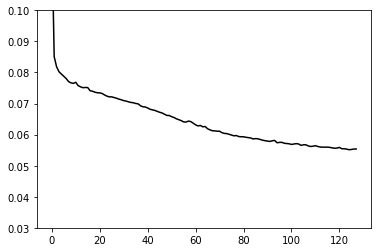

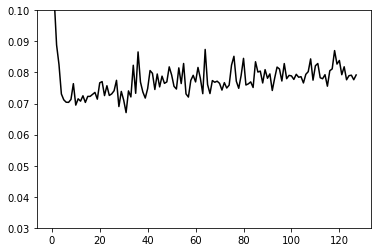

In [255]:

plt.plot(range(len(train_loss_list)), train_loss_list, color='black')
plt.ylim(0.03, 0.1)
plt.show()

plt.plot(range(len(test_loss_list)), test_loss_list, color='black')
plt.ylim((0.03, 0.1))
plt.show()

In [240]:
ae_model.eval()
dnn_model = DNN(ae_model, header_dims, input_dims, window_size).to(device)
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [241]:
pbar = tqdm(range(dnn_epoch), desc="DNN training")
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
for e in pbar:
    dnn_model.train()
    train_running_loss = 0.0
    train_accuracy = 0.0
    for idx, batch in enumerate(tqdm(train_loader)):
        payload, header, label = batch
        payload, header, label = payload.to(device), header.to(device), label.to(device)
        output = dnn_model(payload, header)
        label = label.unsqueeze(1).float()
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted = np.round(output.squeeze(1).detach().cpu())
        label = label.squeeze(1)
        correct = (predicted == label.detach().cpu()).sum().item() / len(label)
        train_accuracy += correct
        train_running_loss += loss.detach().item()
        train_loss_list.append(float(loss))
        pbar.set_postfix(dnn_epoch=f"{e + 1} of {dnn_epoch}", loss=f"{loss:.8f}")
    print('Epoch: %d | Accuracy: %.4f | Loss: %.4f' \
      %(e + 1, train_accuracy/(idx+1), train_running_loss/(idx+1))) 
    train_acc_list.append(train_accuracy/(idx+1))
    dnn_model.eval()
    val_acc = 0.0
    val_loss = 0.0
    for idx, batch in enumerate(test_loader):
        payload, header, label = batch
        payload, header, label = payload.to(device), header.to(device), label.to(device)
        output = dnn_model(payload, header)
        label = label.unsqueeze(1).float()   
        loss = criterion(output, label).detach().cpu()
        predicted = np.round(output.squeeze(1).detach().cpu())
        label = label.squeeze(1)
        correct = (predicted == label.detach().cpu()).sum().item() / len(label)
        val_acc += correct
        val_loss += loss
    print('Epoch: %d | Val Accuracy: %.4f |Val Loss: %.4f' \
      %(e + 1, val_acc/(idx+1) ,val_loss/(idx+1))) 
    val_acc_list.append(val_acc/(idx+1))
    val_loss_list.append(val_loss/(idx+1))
    print("##############" * 3)
    torch.save(dnn_model, os.path.join('./model_save', rf'{e+1}_{val_acc/(idx+1):.4f}.pt'))

DNN training:   0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 | Accuracy: 0.5008 | Loss: 1.1380
Epoch: 1 | Val Accuracy: 0.4962 |Val Loss: 0.6166
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 | Accuracy: 0.5017 | Loss: 0.7489
Epoch: 2 | Val Accuracy: 0.4962 |Val Loss: 0.5952
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 | Accuracy: 0.5008 | Loss: 0.6130
Epoch: 3 | Val Accuracy: 0.4962 |Val Loss: 0.5826
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 | Accuracy: 0.5011 | Loss: 0.7245
Epoch: 4 | Val Accuracy: 0.4962 |Val Loss: 0.5748
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 | Accuracy: 0.5014 | Loss: 0.5838
Epoch: 5 | Val Accuracy: 0.4962 |Val Loss: 0.5699
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 | Accuracy: 0.5017 | Loss: 0.6069
Epoch: 6 | Val Accuracy: 0.4962 |Val Loss: 0.5677
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 | Accuracy: 0.5014 | Loss: 0.5857
Epoch: 7 | Val Accuracy: 0.4962 |Val Loss: 0.5635
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 | Accuracy: 0.5008 | Loss: 0.5688
Epoch: 8 | Val Accuracy: 0.4962 |Val Loss: 0.5604
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 | Accuracy: 0.5008 | Loss: 0.5739
Epoch: 9 | Val Accuracy: 0.4962 |Val Loss: 0.5577
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 | Accuracy: 0.5005 | Loss: 0.5711
Epoch: 10 | Val Accuracy: 0.4962 |Val Loss: 0.5556
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 | Accuracy: 0.5005 | Loss: 0.5635
Epoch: 11 | Val Accuracy: 0.4962 |Val Loss: 0.5532
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 | Accuracy: 0.5008 | Loss: 0.5602
Epoch: 12 | Val Accuracy: 0.4962 |Val Loss: 0.5496
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 | Accuracy: 0.5020 | Loss: 0.5587
Epoch: 13 | Val Accuracy: 0.4962 |Val Loss: 0.5396
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 | Accuracy: 0.5881 | Loss: 0.5388
Epoch: 14 | Val Accuracy: 0.7405 |Val Loss: 0.5187
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 | Accuracy: 0.7150 | Loss: 0.5237
Epoch: 15 | Val Accuracy: 0.7367 |Val Loss: 0.5001
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 | Accuracy: 0.7255 | Loss: 0.5116
Epoch: 16 | Val Accuracy: 0.7386 |Val Loss: 0.4959
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 | Accuracy: 0.7277 | Loss: 0.5082
Epoch: 17 | Val Accuracy: 0.7386 |Val Loss: 0.4966
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 | Accuracy: 0.7275 | Loss: 0.5080
Epoch: 18 | Val Accuracy: 0.7405 |Val Loss: 0.4938
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 | Accuracy: 0.7313 | Loss: 0.4995
Epoch: 19 | Val Accuracy: 0.7386 |Val Loss: 0.4924
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20 | Accuracy: 0.7361 | Loss: 0.5010
Epoch: 20 | Val Accuracy: 0.7348 |Val Loss: 0.4944
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 21 | Accuracy: 0.7596 | Loss: 0.4783
Epoch: 21 | Val Accuracy: 0.7261 |Val Loss: 0.5162
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22 | Accuracy: 0.8288 | Loss: 0.3975
Epoch: 22 | Val Accuracy: 0.7659 |Val Loss: 0.5612
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 23 | Accuracy: 0.9241 | Loss: 0.2304
Epoch: 23 | Val Accuracy: 0.8076 |Val Loss: 0.4640
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 24 | Accuracy: 0.9710 | Loss: 0.1056
Epoch: 24 | Val Accuracy: 0.8197 |Val Loss: 0.4591
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 25 | Accuracy: 0.9790 | Loss: 0.0768
Epoch: 25 | Val Accuracy: 0.8197 |Val Loss: 0.5531
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 26 | Accuracy: 0.9850 | Loss: 0.0490
Epoch: 26 | Val Accuracy: 0.8254 |Val Loss: 0.5681
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 27 | Accuracy: 0.9853 | Loss: 0.0517
Epoch: 27 | Val Accuracy: 0.8311 |Val Loss: 0.5397
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 28 | Accuracy: 0.9930 | Loss: 0.0260
Epoch: 28 | Val Accuracy: 0.8311 |Val Loss: 0.5980
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 29 | Accuracy: 0.9917 | Loss: 0.0283
Epoch: 29 | Val Accuracy: 0.8254 |Val Loss: 0.6027
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 30 | Accuracy: 0.9860 | Loss: 0.0441
Epoch: 30 | Val Accuracy: 0.8216 |Val Loss: 0.5849
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 31 | Accuracy: 0.9949 | Loss: 0.0164
Epoch: 31 | Val Accuracy: 0.8159 |Val Loss: 0.5771
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 32 | Accuracy: 0.9905 | Loss: 0.0234
Epoch: 32 | Val Accuracy: 0.8121 |Val Loss: 0.6366
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 33 | Accuracy: 0.9917 | Loss: 0.0233
Epoch: 33 | Val Accuracy: 0.8273 |Val Loss: 0.6945
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 34 | Accuracy: 0.9892 | Loss: 0.0312
Epoch: 34 | Val Accuracy: 0.8216 |Val Loss: 0.6551
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 35 | Accuracy: 0.9962 | Loss: 0.0145
Epoch: 35 | Val Accuracy: 0.8140 |Val Loss: 0.6725
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 36 | Accuracy: 0.9911 | Loss: 0.0235
Epoch: 36 | Val Accuracy: 0.8159 |Val Loss: 0.6459
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 37 | Accuracy: 0.9923 | Loss: 0.0311
Epoch: 37 | Val Accuracy: 0.8311 |Val Loss: 0.5982
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 38 | Accuracy: 0.9936 | Loss: 0.0241
Epoch: 38 | Val Accuracy: 0.8322 |Val Loss: 0.5570
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 39 | Accuracy: 0.9952 | Loss: 0.0805
Epoch: 39 | Val Accuracy: 0.8330 |Val Loss: 0.5926
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 40 | Accuracy: 0.9974 | Loss: 0.0117
Epoch: 40 | Val Accuracy: 0.8121 |Val Loss: 0.7894
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 41 | Accuracy: 0.9949 | Loss: 0.0143
Epoch: 41 | Val Accuracy: 0.8398 |Val Loss: 0.5685
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 42 | Accuracy: 0.9981 | Loss: 0.0092
Epoch: 42 | Val Accuracy: 0.8311 |Val Loss: 0.6486
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 43 | Accuracy: 0.9987 | Loss: 0.0049
Epoch: 43 | Val Accuracy: 0.8341 |Val Loss: 0.5897
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 44 | Accuracy: 0.9923 | Loss: 0.0230
Epoch: 44 | Val Accuracy: 0.8178 |Val Loss: 0.8253
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 45 | Accuracy: 0.9904 | Loss: 0.0246
Epoch: 45 | Val Accuracy: 0.8102 |Val Loss: 0.7612
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 46 | Accuracy: 0.9904 | Loss: 0.0354
Epoch: 46 | Val Accuracy: 0.8102 |Val Loss: 0.8463
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 47 | Accuracy: 0.9949 | Loss: 0.0199
Epoch: 47 | Val Accuracy: 0.8197 |Val Loss: 0.7938
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 48 | Accuracy: 0.9949 | Loss: 0.0137
Epoch: 48 | Val Accuracy: 0.8083 |Val Loss: 0.7592
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 49 | Accuracy: 0.9917 | Loss: 0.0185
Epoch: 49 | Val Accuracy: 0.8159 |Val Loss: 0.7204
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 50 | Accuracy: 0.9968 | Loss: 0.0123
Epoch: 50 | Val Accuracy: 0.8140 |Val Loss: 0.9232
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 51 | Accuracy: 0.9924 | Loss: 0.0241
Epoch: 51 | Val Accuracy: 0.8216 |Val Loss: 0.7359
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 52 | Accuracy: 0.9968 | Loss: 0.0099
Epoch: 52 | Val Accuracy: 0.8216 |Val Loss: 0.6696
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 53 | Accuracy: 0.9955 | Loss: 0.0167
Epoch: 53 | Val Accuracy: 0.8322 |Val Loss: 0.5854
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 54 | Accuracy: 0.9968 | Loss: 0.0098
Epoch: 54 | Val Accuracy: 0.8246 |Val Loss: 0.5685
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 55 | Accuracy: 0.9968 | Loss: 0.0089
Epoch: 55 | Val Accuracy: 0.8178 |Val Loss: 0.6292
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 56 | Accuracy: 0.9987 | Loss: 0.0050
Epoch: 56 | Val Accuracy: 0.8197 |Val Loss: 0.6515
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 57 | Accuracy: 0.9994 | Loss: 0.0028
Epoch: 57 | Val Accuracy: 0.8311 |Val Loss: 0.8034
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 58 | Accuracy: 0.9946 | Loss: 0.0105
Epoch: 58 | Val Accuracy: 0.8292 |Val Loss: 0.7655
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 59 | Accuracy: 0.9981 | Loss: 0.0068
Epoch: 59 | Val Accuracy: 0.8405 |Val Loss: 0.6359
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 60 | Accuracy: 0.9955 | Loss: 0.0109
Epoch: 60 | Val Accuracy: 0.8254 |Val Loss: 0.6133
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 61 | Accuracy: 0.9968 | Loss: 0.0079
Epoch: 61 | Val Accuracy: 0.8303 |Val Loss: 0.5780
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 62 | Accuracy: 0.9949 | Loss: 0.0161
Epoch: 62 | Val Accuracy: 0.8341 |Val Loss: 0.5916
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 63 | Accuracy: 0.9965 | Loss: 0.0140
Epoch: 63 | Val Accuracy: 0.8235 |Val Loss: 0.6750
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 64 | Accuracy: 0.9930 | Loss: 0.0196
Epoch: 64 | Val Accuracy: 0.8492 |Val Loss: 0.5106
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 65 | Accuracy: 0.9914 | Loss: 0.0223
Epoch: 65 | Val Accuracy: 0.8348 |Val Loss: 0.6265
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 66 | Accuracy: 0.9930 | Loss: 0.0193
Epoch: 66 | Val Accuracy: 0.8197 |Val Loss: 0.6770
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 67 | Accuracy: 0.9955 | Loss: 0.0124
Epoch: 67 | Val Accuracy: 0.8246 |Val Loss: 0.6169
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 68 | Accuracy: 0.9974 | Loss: 0.0083
Epoch: 68 | Val Accuracy: 0.8216 |Val Loss: 0.7259
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 69 | Accuracy: 0.9972 | Loss: 0.0072
Epoch: 69 | Val Accuracy: 0.8216 |Val Loss: 0.7376
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 70 | Accuracy: 0.9981 | Loss: 0.0074
Epoch: 70 | Val Accuracy: 0.8273 |Val Loss: 0.6381
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 71 | Accuracy: 0.9981 | Loss: 0.0041
Epoch: 71 | Val Accuracy: 0.8216 |Val Loss: 0.6606
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 72 | Accuracy: 0.9974 | Loss: 0.0069
Epoch: 72 | Val Accuracy: 0.8178 |Val Loss: 0.7891
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 73 | Accuracy: 0.9987 | Loss: 0.0043
Epoch: 73 | Val Accuracy: 0.8216 |Val Loss: 0.6973
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 74 | Accuracy: 1.0000 | Loss: 0.0018
Epoch: 74 | Val Accuracy: 0.8197 |Val Loss: 0.8594
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 75 | Accuracy: 0.9981 | Loss: 0.0098
Epoch: 75 | Val Accuracy: 0.8216 |Val Loss: 0.8849
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 76 | Accuracy: 0.9968 | Loss: 0.0116
Epoch: 76 | Val Accuracy: 0.8178 |Val Loss: 0.6594
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 77 | Accuracy: 0.9981 | Loss: 0.0138
Epoch: 77 | Val Accuracy: 0.8273 |Val Loss: 0.7705
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 78 | Accuracy: 0.9981 | Loss: 0.0080
Epoch: 78 | Val Accuracy: 0.8235 |Val Loss: 0.8087
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 79 | Accuracy: 0.9987 | Loss: 0.0059
Epoch: 79 | Val Accuracy: 0.8273 |Val Loss: 0.8251
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 80 | Accuracy: 0.9991 | Loss: 0.0021
Epoch: 80 | Val Accuracy: 0.8273 |Val Loss: 0.7732
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 81 | Accuracy: 0.9974 | Loss: 0.0079
Epoch: 81 | Val Accuracy: 0.8140 |Val Loss: 0.9380
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 82 | Accuracy: 0.9949 | Loss: 0.0151
Epoch: 82 | Val Accuracy: 0.8341 |Val Loss: 0.7077
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 83 | Accuracy: 0.9987 | Loss: 0.0067
Epoch: 83 | Val Accuracy: 0.8322 |Val Loss: 0.6266
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 84 | Accuracy: 0.9930 | Loss: 0.0228
Epoch: 84 | Val Accuracy: 0.8398 |Val Loss: 0.6264
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 85 | Accuracy: 0.9981 | Loss: 0.0080
Epoch: 85 | Val Accuracy: 0.8246 |Val Loss: 0.6113
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 86 | Accuracy: 1.0000 | Loss: 0.0012
Epoch: 86 | Val Accuracy: 0.8379 |Val Loss: 0.6583
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 87 | Accuracy: 0.9974 | Loss: 0.0048
Epoch: 87 | Val Accuracy: 0.8284 |Val Loss: 0.6280
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 88 | Accuracy: 0.9994 | Loss: 0.0035
Epoch: 88 | Val Accuracy: 0.8311 |Val Loss: 0.8094
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 89 | Accuracy: 1.0000 | Loss: 0.0020
Epoch: 89 | Val Accuracy: 0.8386 |Val Loss: 0.7670
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 90 | Accuracy: 0.9994 | Loss: 0.0032
Epoch: 90 | Val Accuracy: 0.8227 |Val Loss: 0.6497
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 91 | Accuracy: 1.0000 | Loss: 0.0016
Epoch: 91 | Val Accuracy: 0.8379 |Val Loss: 0.6333
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 92 | Accuracy: 0.9968 | Loss: 0.0072
Epoch: 92 | Val Accuracy: 0.8348 |Val Loss: 0.7434
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 93 | Accuracy: 1.0000 | Loss: 0.0008
Epoch: 93 | Val Accuracy: 0.8189 |Val Loss: 0.6872
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 94 | Accuracy: 0.9978 | Loss: 0.0053
Epoch: 94 | Val Accuracy: 0.8159 |Val Loss: 0.7140
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 95 | Accuracy: 0.9994 | Loss: 0.0022
Epoch: 95 | Val Accuracy: 0.8273 |Val Loss: 0.7028
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 96 | Accuracy: 0.9974 | Loss: 0.0052
Epoch: 96 | Val Accuracy: 0.8235 |Val Loss: 0.6959
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 97 | Accuracy: 0.9981 | Loss: 0.0054
Epoch: 97 | Val Accuracy: 0.8254 |Val Loss: 0.6979
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 98 | Accuracy: 0.9981 | Loss: 0.0050
Epoch: 98 | Val Accuracy: 0.8254 |Val Loss: 0.7097
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 99 | Accuracy: 0.9987 | Loss: 0.0045
Epoch: 99 | Val Accuracy: 0.8208 |Val Loss: 0.7049
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 100 | Accuracy: 0.9949 | Loss: 0.0123
Epoch: 100 | Val Accuracy: 0.8227 |Val Loss: 0.6838
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 101 | Accuracy: 0.9987 | Loss: 0.0046
Epoch: 101 | Val Accuracy: 0.8292 |Val Loss: 0.7250
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 102 | Accuracy: 1.0000 | Loss: 0.0009
Epoch: 102 | Val Accuracy: 0.8197 |Val Loss: 0.8672
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 103 | Accuracy: 0.9994 | Loss: 0.0016
Epoch: 103 | Val Accuracy: 0.8208 |Val Loss: 0.7579
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 104 | Accuracy: 0.9936 | Loss: 0.0226
Epoch: 104 | Val Accuracy: 0.7970 |Val Loss: 1.4551
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 105 | Accuracy: 0.9981 | Loss: 0.0045
Epoch: 105 | Val Accuracy: 0.8197 |Val Loss: 0.7726
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 106 | Accuracy: 0.9981 | Loss: 0.0042
Epoch: 106 | Val Accuracy: 0.8216 |Val Loss: 0.9612
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 107 | Accuracy: 0.9981 | Loss: 0.0050
Epoch: 107 | Val Accuracy: 0.8140 |Val Loss: 0.7830
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 108 | Accuracy: 0.9965 | Loss: 0.0067
Epoch: 108 | Val Accuracy: 0.8254 |Val Loss: 0.8945
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 109 | Accuracy: 0.9974 | Loss: 0.0046
Epoch: 109 | Val Accuracy: 0.8311 |Val Loss: 0.7879
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 110 | Accuracy: 0.9987 | Loss: 0.0045
Epoch: 110 | Val Accuracy: 0.8254 |Val Loss: 0.8741
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 111 | Accuracy: 0.9987 | Loss: 0.0026
Epoch: 111 | Val Accuracy: 0.8265 |Val Loss: 0.7706
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 112 | Accuracy: 0.9987 | Loss: 0.0041
Epoch: 112 | Val Accuracy: 0.8330 |Val Loss: 0.7613
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 113 | Accuracy: 0.9974 | Loss: 0.0075
Epoch: 113 | Val Accuracy: 0.8254 |Val Loss: 0.7123
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 114 | Accuracy: 0.9987 | Loss: 0.0041
Epoch: 114 | Val Accuracy: 0.8254 |Val Loss: 1.3361
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 115 | Accuracy: 0.9994 | Loss: 0.0023
Epoch: 115 | Val Accuracy: 0.8197 |Val Loss: 0.9961
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 116 | Accuracy: 0.9981 | Loss: 0.0086
Epoch: 116 | Val Accuracy: 0.8152 |Val Loss: 0.7252
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 117 | Accuracy: 1.0000 | Loss: 0.0007
Epoch: 117 | Val Accuracy: 0.8284 |Val Loss: 0.7210
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 118 | Accuracy: 0.9994 | Loss: 0.0030
Epoch: 118 | Val Accuracy: 0.8216 |Val Loss: 1.1204
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 119 | Accuracy: 0.9968 | Loss: 0.0096
Epoch: 119 | Val Accuracy: 0.8254 |Val Loss: 0.8472
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 120 | Accuracy: 0.9994 | Loss: 0.0018
Epoch: 120 | Val Accuracy: 0.8330 |Val Loss: 0.6893
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 121 | Accuracy: 1.0000 | Loss: 0.0021
Epoch: 121 | Val Accuracy: 0.8235 |Val Loss: 0.7963
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 122 | Accuracy: 0.9974 | Loss: 0.0106
Epoch: 122 | Val Accuracy: 0.8265 |Val Loss: 0.6648
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 123 | Accuracy: 0.9994 | Loss: 0.0034
Epoch: 123 | Val Accuracy: 0.8292 |Val Loss: 0.6927
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 124 | Accuracy: 0.9994 | Loss: 0.0019
Epoch: 124 | Val Accuracy: 0.8311 |Val Loss: 0.7499
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 125 | Accuracy: 0.9949 | Loss: 0.0163
Epoch: 125 | Val Accuracy: 0.8045 |Val Loss: 1.0891
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 126 | Accuracy: 0.9981 | Loss: 0.0046
Epoch: 126 | Val Accuracy: 0.8254 |Val Loss: 0.8931
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 127 | Accuracy: 0.9987 | Loss: 0.0049
Epoch: 127 | Val Accuracy: 0.8284 |Val Loss: 0.7206
##########################################


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 128 | Accuracy: 0.9994 | Loss: 0.0021
Epoch: 128 | Val Accuracy: 0.8273 |Val Loss: 0.7423
##########################################


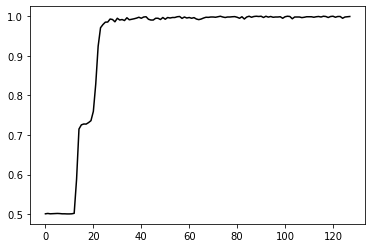

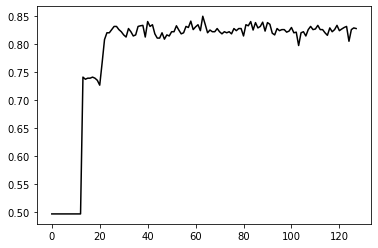

In [242]:
# train_acc_list
plt.plot(range(len(train_acc_list)), train_acc_list, color='black')
plt.show()

plt.plot(range(len(val_acc_list)), val_acc_list, color='black')
plt.show()

In [243]:
dnn_model.eval()
test_acc = 0.0
test_pred = []
for idx, batch in enumerate(valid_loader):
    payload, header, label = batch
    payload, header, label = payload.to(device), header.to(device), label.to(device)
    output = dnn_model(payload, header)
    label = label.unsqueeze(1).float()   
    loss = criterion(output, label).detach().cpu()
    predicted = np.round(output.squeeze(1).detach().cpu())
    label = label.squeeze(1)
    correct = (predicted == label.detach().cpu()).sum().item() / len(label)
    test_acc += correct
    test_pred += predicted
print('Test Accuracy: %.4f' \
  %(test_acc/(idx+1) )) 

Test Accuracy: 0.8356


In [244]:
def get_f1(labels, pred):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(pred)):
        if pred[i] == 1 :
            if labels[i] != 0:
                tp += 1
            else:
                fp += 1
        else:
            if labels[i] != 0:
                fn += 1
            else:
                tn += 1
    accuracy = (tp+tn)/(len(pred))
    recall = tp/(fn+tp)
    precision = tp/(fp+tp)
    print("Accuracy :", accuracy)
    print("Recall :", recall)
    print("Precision :", precision)
    print("F1 :", 2*(1/(1/recall + 1/precision)))

In [ ]:
get_f1(test_dataset.label, test_pred)